<a href="https://colab.research.google.com/github/rahiakela/pytorch-computer-vision-cookbook/blob/main/2-binary-image-classification/1_binary_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Image Classification

Image classification (also called image recognition) is an important task in computer vision. In this task, we assume that images contain one main object. Here, our goal is to classify the main object. There are two types of image classification: **binary classification and multi-class classification**.

The goal of binary image classification is to classify images into two categories. For instance, we may want to know if a medical image is normal or malignant. The images could be grayscale with one channel or color image with three channels.

In this notebook, we'll also learn how to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

In particular, we will cover the following recipes:
- **Exploring the dataset**
- **Creating a custom dataset**
- **Splitting the dataset**
- **Transforming the data**
- **Creating dataloaders**
- **Building the classification model**
- **Defining the loss function**
- **Defining the optimizer**
- **Training and evaluation of the model**
- **Deploying the model**
- **Model inference on test data**

## Setup

In [1]:
import pandas as pd 
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import copy
import os

import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

np.random.seed(0)

%matplotlib inline

## Exploring the dataset

We'll use the dataset provided in the [Histopathologic Cancer Detection competition on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview). The goal of this competition is to classify image patches as normal or malignant. In this section, we will investigate the dataset.

### Load dataset from Kaggle

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

First of all, needs to copy kaggle.json file to .kaggle directory

In [3]:
# copy kaggle.json file to .kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Try to downlaod data for the histopathologic-cancer-detection challenge.
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [02:19<00:00, 27.6MB/s]
100% 6.31G/6.31G [02:19<00:00, 48.5MB/s]


After downloading it, extract the ZIP files into a folder named data.

Inside the data folder, there are two folders: `train` and `test`. The train folder contains 220,025 `.tif` images that are 96x96 in size. The `.tif` images are named with an image ID. The `train_labels.csv` file provides the ground truth for the images in the train folder.

In [5]:
import os, shutil
import zipfile

# path to the directory where the original dataset was uncompressed
original_dataset_dir = 'data'

# remove directories if it already exists
shutil.rmtree(original_dataset_dir, ignore_errors=True)

# create directories
os.mkdir(original_dataset_dir)

# unzip dataset
with zipfile.ZipFile("histopathologic-cancer-detection.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

In [6]:
# delete the zip file
!rm -rf histopathologic-cancer-detection.zip

There are no labels for the test images. If we were to compete in the competition, we would need to provide predictions on the test dataset and submit them to the competition for evaluation.

To learn about the dataset, we'll start by loading the labels and displaying a few sample images from the dataset:

In [7]:
# Let's begin by reading train_labels.csv and printing out its head
labels_df = pd.read_csv("./data/train_labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
# Let's count the number of normal and malignant cases:
print(labels_df["label"].value_counts())

0    130908
1     89117
Name: label, dtype: int64


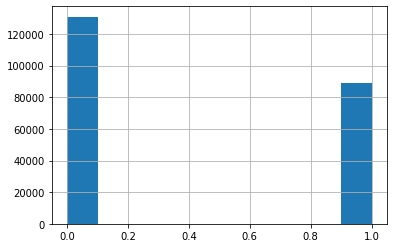

In [9]:
# Let's look at a histogram of the labels
labels_df["label"].hist()

Let's visualize a few images that have a positive label. A positive label shows that the center 32 x 32 region of an image contains at least one pixel of tumor tissue.

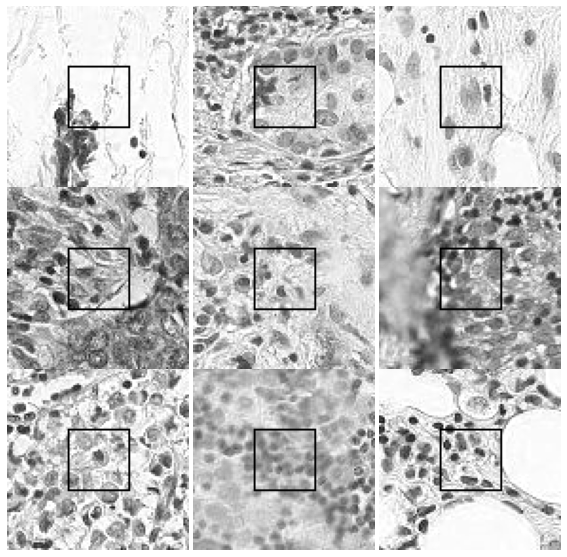

In [10]:
# get ids for malignant images
malignant_ids = labels_df.loc[labels_df["label"]==1]["id"].values

# data is stored here
train_data = "./data/train/"

# show images in grayscale, if you want color change it to True
color = False

# set the figure sizes
plt.rcParams["figure.figsize"] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3

# display the images
for i, id_ in enumerate(malignant_ids[:nrows * ncols]):
  full_filenames = os.path.join(train_data, id_ + ".tif")
  # load image
  img = Image.open(full_filenames)
  # draw a 32*32 rectangle
  draw = ImageDraw.Draw(img)
  draw.rectangle(((32, 32), (64, 64)), outline="green")
  plt.subplot(nrows, ncols, i + 1)

  if color is True:
    plt.imshow(np.array(img))
  else:
    plt.imshow(np.array(img)[:, :, 0], cmap="gray")
  plt.axis("off")

Let's also get the image's shape and minimum and maximum pixel values.

In [11]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


It is really difficult to tell whether an image is malignant just by looking at it. So, you can imagine why it's a difficult task for clinicians to inspect so many images every day. Hopefully, we can develop an automated tool to help them in their routine tasks.

## Creating a custom dataset

A traditional method for working with a dataset would be to load all images into NumPy arrays. Since we are dealing with a relatively large dataset, this would be a waste of our computer resources. If you are short on RAM, this would be impossible.Luckily, PyTorch has a powerful tool to handle large datasets.

We can create a custom Dataset class by subclassing the PyTorch Dataset class. When creating a custom Dataset class, make sure to define two essential functions: `__len__` and `__getitem__`. The `__len__` function returns the dataset's length. This function is callable with the Python len function. The `__getitem__` function returns an image at the specified index.

We will define a class for the custom dataset, define the transformation function, and then load an image from the dataset using the
class Dataset.

In [12]:
# Don't forget to fix the random seed for reproducibility:
torch.manual_seed(0)

class HistoCancerDataset(Dataset):

  def __init__(self, data_dir, transform, data_type="train"):
    # path to images
    img_path = os.path.join(data_dir, data_type)
    # get a list of images
    filenames = os.listdir(img_path)
    # get the full path to images
    self.full_filenames = [os.path.join(img_path, f) for f in filenames]

    # labels are in a csv file named train_labels.csv
    csv_filename = data_type + "_labels.csv"
    csv_labels_path = os.path.join(data_dir, csv_filename)
    labels_df = pd.read_csv(csv_labels_path)

    # set data frame index to id
    labels_df.set_index("id", inplace=True)

    # obtain labels from data frame
    self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
    self.transform = transform

  def __len__(self):
    # return size of dataset
    return len(self.full_filenames)

  def __getitem__(self, idx):
    # open image, apply transforms and return with label
    image = Image.open(self.full_filenames[idx])
    image = self.transform(image)

    return image, self.labels[idx]

Next, we will define a simple transformation that only converts a PIL image into
PyTorch tensors.

In [13]:
# converts a PIL image into the range [0, 255] to torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
data_transformer = transforms.Compose([transforms.ToTensor()])

Then, we will define an object of the custom dataset for the train folder:

In [14]:
data_dir = "./data"
histo_dataset = HistoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


Next, we will load an image using the custom dataset:

In [15]:
# load an image
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


## Splitting the dataset

We need to provide a validation dataset to track the model's performance during training. We use 20% of histo_dataset as the validation dataset and use the rest as the training dataset.

We will split the dataset into training and validation and then display a few sample images from each dataset.

In [16]:
# Let's split histo_dataset
len_histo = len(histo_dataset)
len_train = int(0.8 * len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])
print("Train dataset length:", len(train_ds))
print("Validation dataset length:", len(val_ds))

Train dataset length: 176020
Validation dataset length: 44005


In [17]:
# Then, we can get an image from the training dataset
for x, y in train_ds:
  print(x.shape, y)
  break

torch.Size([3, 96, 96]) 1


In [18]:
# We will also get an image from the validation dataset
for x, y in val_ds:
  print(x.shape, y)
  break

torch.Size([3, 96, 96]) 0


Let's display a few samples from train_ds.

In [19]:
def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


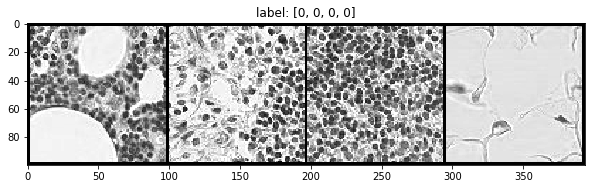

In [20]:
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


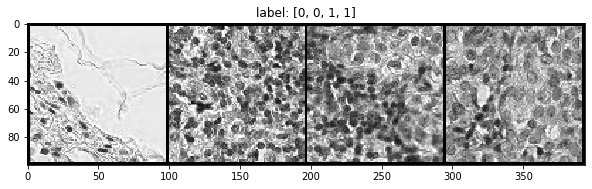

In [21]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)

## Transforming the data

Image transformation and image augmentation are necessary for training deep learning models. By using image transformations, we can expand our dataset or resize and normalize it to achieve better model performance. Typical transformations include horizontal and vertical flipping, rotation, and resizing. The good news is that we can use various image transformations for our binary classification model without making label changes. 

For instance, if we rotate or flip a malignant image, it will remain malignant. In this recipe, you will learn how to use the torchvision package to perform on-the-fly image transformation during training.

In [22]:
# First, let's define the following transformations for the training dataset
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    transforms.ToTensor()                                   
])

For the validation dataset, we don't need any augmentation. So, we only convert
the images into tensors in the transforms function:

In [23]:
val_transformer = transforms.Compose([transforms.ToTensor()])

After defining the transformations, we overwrite the transform functions
of train_ds and val_ds:

In [24]:
train_ds.transform = train_transformer
val_ds.transform = val_transformer

## Creating dataloaders

We are ready to create a PyTorch dataloader. If we do not use dataloaders, we have to write code to loop over datasets and extract a data batch. This process can be made automatically using a PyTorch Dataloader.

First, let's define two dataloaders for the datasets:

In [25]:
train_data_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

Then, we get a data batch from the training dataloader:

In [26]:
# extract a batch from training data
for x, y in train_data_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 3, 96, 96])
torch.Size([32])


Next, we get a data batch from the validation dataloader:

In [27]:
for x, y in val_data_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 3, 96, 96])
torch.Size([64])


when defining a PyTorch Dataloader, we need to define the batch size. The batch
size determines the number of images to be extracted from the dataset in each iteration. The typical values of the batch size for classification tasks are in the range of `[8-128]`. Also, note that we do not need to shuffle the validation data during evaluation.

## Building the classification model

we will build a model for our binary classification task. Our model is
comprised of four convolutional neural networks (CNNs) and two fully connected layers.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-pytorch/conv-diagram.png?raw=1' width='800'/>

As we can see, there are four convolutional layers and two fully connected layers in the model. After each convolutional layer, there is a pooling layer. The convolutional layers process the input image and extract a feature vector, which is fed to the fully connected layers. There is an output layer for the binary classification.

**Step-1**:First, let's create dumb baselines for the validation dataset.

We should always establish a baseline before moving forward with complex models. This will help us find out how well we are performing. We can create dumb baselines by creating random predictions, all-zero predictions, or all-one
predictions.

In [28]:
# get labels for validation dataset
y_val = [y for _, y in val_ds]

# Next, we will define a function to calculate the classification accuracy:
def accuracy(labels, out):
  return np.sum(out==labels) / float(len(labels))

# Then, we will calculate a dumb baseline for all-zero predictions:
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" % acc_all_zeros)

accuracy all zero prediction: 0.59


It is interesting to see that we can get an accuracy of 0.60 with dumb predictions.

In [29]:
# Next, we will calculate a dumb baseline for all-one predictions:
acc_all_ones = accuracy(y_val, np.ones_like(y_val))
print("accuracy all one prediction: %.2f" % acc_all_ones)

accuracy all one prediction: 0.41


In [30]:
# Next, we will calculate a dumb baseline for random predictions:
acc_random = accuracy(y_val, np.random.randint(2, size=len(y_val)))
print("accuracy random prediction: %.2f" % acc_random)

accuracy random prediction: 0.50


**Step-2**: Let's implement a helper function to calculate the output size of a CNN layer.

In [31]:
def findConv2dOutShape(H_in, W_in, conv, pool=2):
  #  get conv arguments
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation

  # Ref: https://pytorch.org/docs/stable/nn.html
  H_out = np.floor((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
  W_out = np.floor((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

  if pool:
    H_out /= pool
    W_out /= pool
  return int(H_out), int(W_out)

In [32]:
# Next, we will look at the helper function using an example:
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h, w = findConv2dOutShape(96, 96, conv1)
print(h, w)

47 47


**Step-3**: Next, we will implement the CNN model.

In the `__init__` function, we define the layers of the model. We provide the model parameters as a Python dictionary to this function. We recommend using variables for the model parameters and a dictionary to define them outside the class. This way, in the case of parameter changes, we do not have to make changes inside the Net class. This will also make future hyperparameter searches easier.

In the forward function, we use the defined layers to outline the model. We use
`nn.Conv2d` and `nn.Linear` to define the CNN and fully connected layers, respectively. The pooling layers, activations, and dropout layers act like functions and can be defined using `nn.functional`. We do not need to define these layers in the `__init__` function.

In [37]:
# Define the Net class
class Net(nn.Module):

  def __init__(self, params):
    super(Net, self).__init__()
    C_in, H_in, W_in = params["input_shape"]
    init_f = params["initial_filters"]
    num_fc1 = params["num_fc1"]
    num_classes = params["num_classes"]

    self.dropout_rate = params["dropout_rate"]

    # For most layers, it is important to specify the number of inputs and outputs of the layer.
    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h, w = findConv2dOutShape(H_in, W_in, self.conv1)

    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv2)

    self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv3)

    self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h, w, self.conv4)

    # compute the flatten size
    self.num_flatten = h * w * 8 * init_f

    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)

    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, self.num_flatten)

    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout_rate)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

**Step-4**:Then, we will construct an object of the Net class:

In [38]:
# dict to define model parameters
params_model = {
    "input_shape": (3, 96, 96),
    "initial_filters": 8,
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}

# create model
cnn_model = Net(params_model)

**Step-5**: Move the model to a cuda device if one's available.

if you have a CUDA device, always move the model to the CUDA device to take
advantage of the computation acceleration.

In [39]:
# move model to cuda/gpu device
if torch.cuda.is_available:
  device = torch.device("cuda")
  cnn_model = cnn_model.to(device)

print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [40]:
# Verify the model device
print(next(cnn_model.parameters()).device)

cuda:0


**Step-6**: Let's get a summary of the model

In [41]:
summary(cnn_model, input_size=(3, 96, 96), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


## Defining the loss function